# Tracking the objects in 3D using Kalman filter and hungarian algorithm on Kitti dataset

download the kitti dataset and calibration files by uncommenting below lines


In [579]:
#!python -m wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
#!python -m wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
#!python -m wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
#%pip install filterpy

# a) Object Detection

Before tracking the objects we need to detect it.

In [580]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kitti_utils import *
from kitti_detection_utils import *

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

In [581]:
file_path = r'2011_10_03_drive_0047_sync/2011_10_03/2011_10_03_drive_0047_sync'

# getting camera RGB data
left_img = sorted(glob(os.path.join(file_path, 'image_02/data/*.png')))
right_img = sorted(glob(os.path.join(file_path, 'image_03/data/*.png')))

#getting lidar data
bin_path = sorted(glob(os.path.join(file_path,'velodyne_points/data/*.bin')))

#getting GPS/IMU data
oxts_path = sorted(glob(os.path.join(file_path,r'oxts/data**/*.txt')))

assert len(left_img) == len(bin_path)

print(f"Number of left images: {len(left_img)}")
print(f"Number of right images: {len(right_img)}")
print(f"Number of Lidar point clouds: {len(bin_path)}")
print(f"Number of GPS/IMU frames: {len(oxts_path)}")

Number of left images: 837
Number of right images: 837
Number of Lidar point clouds: 837
Number of GPS/IMU frames: 837


In [582]:
def timestamps2seconds(timestamp_path):
    # Read timestamps and extract the time part (after space)
    timestamps = pd.read_csv(timestamp_path, header=None).iloc[:, 0].str.split(' ').str[1]
    
    # Split into hours, minutes, seconds and convert to numeric
    hms = timestamps.str.split(':', expand=True).astype(float)
    
    # Calculate total seconds
    total_seconds = hms[0] * 3600 + hms[1] * 60 + hms[2]
    
    return total_seconds.values  # Return as numpy array

cam2_total_seconds = timestamps2seconds(os.path.join(file_path, 'image_02/timestamps.txt'))
print(f'Number of time stamps: {len(cam2_total_seconds)}')

Number of time stamps: 837


Get the Camera calibration data and transformation matrix

In [583]:
with open('2011_10_03_calib/2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib_cam = f.readlines()

# get projection matrices (Rectified left camera --> Left camera (u,v,z))
rect2_cam2 = np.array([float(x) for x in calib_cam[25].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices (Left camera --> rectified left camera)
R_rect2 = np.array([float(x) for x in calib_cam[24].strip().split(' ')[1:]]).reshape((3,3))

# convert to homogenous coordinates
R_rect2 = np.insert(R_rect2,3, values=[0,0,0], axis =0)
R_rect2 = np.insert(R_rect2,3, values=[0,0,0,1], axis =1)

# get transformation from camera 0 to camera 1
R_c0_c2 = np.array([float(x) for x in calib_cam[21].strip().split(' ')[1:]]).reshape((3,3))
T_c0_c2 = np.array([float(x) for x in calib_cam[22].strip().split(' ')[1:]]).reshape((3,1))

# get cam0 to cam2 transformation in homgenous coordinates
T_rect2 = np.insert(np.hstack((R_c0_c2,T_c0_c2)), 3, values = [0,0,0,1], axis=0)

Similarly get the Lidar and IMU calibration data and their transformations to camera

In [584]:
T_lid = get_rigid_transformation(r'2011_10_03_calib/2011_10_03/calib_velo_to_cam.txt')
T_imu = get_rigid_transformation(r'2011_10_03_calib/2011_10_03/calib_imu_to_velo.txt')

# transform from Lidar to left color camera and camera to lidar
T_lid_cam2 = rect2_cam2 @ R_rect2 @ T_rect2 @ T_lid
T_cam2_lid = np.linalg.inv(np.insert(T_lid_cam2, 3, values=[0,0,0,1], axis = 0))

# transform from imu to camera and camera to imu
T_imu_cam2 = T_lid_cam2 @ T_imu
T_cam2_imu = np.linalg.inv(np.insert(T_imu_cam2,3 , values=[0,0,0,1], axis = 0))

Getting Yolo object detection pipeline

In [585]:
#!git clone https://github.com/ultralytics/yolov5
#%pip install -r yolov5/requirements.txt
#!python -m wget https://github.com/ultralytics/yolov5/raw/master/data/coco.yaml

# get the model
import torch
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\toukh/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-3-31 Python-3.11.0 torch-2.3.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [586]:
# set model confidence and IOU thresholds
model.conf = 0.25 # confidence threshold (0-1), default: 0.25
model.iou = 0.25 # NMS IoU threshold (0-1), default: 0.45

## Tracking Pipeline

**Hungarian Algorithm-Based Object Association**

Performs frame-to-frame object matching using the Hungarian algorithm with L2 distance cost.

In [587]:
from scipy.optimize import linear_sum_assignment

def total_cost(center1, center2):
    return np.linalg.norm(center1 - center2)

def associate(old_centers, new_centers, dist_thresh = 1):
    """
        Matches detected objects between consecutive frames for tracking.

        inputs :

        old_centers: Array[N,2] - Previous frame's object centers (x,y)
        new_centers: Array[M,2] - Current frame's detected centers (x,y)
        dist_thresh: float - Maximum L2 distance for valid matches (default: 1)

        Returns:

        matches: Array[K,2] - Matched indices as (old_idx, new_idx) pairs
        unmatched_detections: List - New detections without matches
        unmatched_tracks: List - Previous tracks without matches

    """
    if (len(new_centers) == 0) and (len(old_centers) == 0):
        return [], [], []
    elif(len(old_centers) == 0):
        return [], new_centers, []
    elif(len(new_centers) == 0):
        return [], [], old_centers
    
    # distances will store L2 distances between object centers
    distances = np.zeros((len(old_centers),len(new_centers)), dtype=np.float32)

    # Go through centers and store the distances between all of them
    for i, old_cntr in enumerate(old_centers):
        for j,new_cntr in enumerate(new_centers):
            distances[i][j] = total_cost(old_cntr, new_cntr)

    # Hungarian Algorithm (with distance metric as the cost)
    row_ind, col_ind = linear_sum_assignment(distances)
    hungarian_matrix = np.array(list(zip(row_ind, col_ind)))

    # Create new unmatched lists for old and new boxes
    matches, unmatched_detections, unmatched_tracks = [], [], []

    # Go through the Hungarian Matrix, if matched element has dist <= threshold , add it to the unmatched
    # Else: add the match
    for h in hungarian_matrix:
        if(distances[h[0],h[1]] > dist_thresh):
            unmatched_tracks.append(old_centers[h[0]])
            unmatched_detections.append(new_centers[h[1]])
        else:
            matches.append(h.reshape(1,2))

    if(len(matches) == 0):
        matches = np.empty((0,2), dtype=int)
    else:
        matches = np.concatenate(matches, axis = 0)

    # After filtering matches by threshold, collect all rejected tracks
    rejected_tracks = [h[0] for h in hungarian_matrix if distances[h[0], h[1]] > dist_thresh]
    
    # Go through old centers, if no matched detection, add it to the unmatched_old_centers
    for t, trk in enumerate(old_centers):
        if(t not in hungarian_matrix[:,0]  or t in rejected_tracks):
            unmatched_tracks.append(trk)
    
    # Go through new boxes, if no matched tracking, add it to the unmatched_new_centers
    for d, det in enumerate(new_centers):
        if(d not in hungarian_matrix[:,1]):
            unmatched_detections.append(det)
    
    return matches, unmatched_detections, unmatched_tracks

In [588]:
import yaml

with open('coco.yaml', 'r', encoding = 'utf-8') as stream:
    try:
        classes = yaml.safe_load(stream)['names']
    except yaml.YAMLError as exc:
        print(exc)


In [589]:
def get_color(idx):
    """
        Generates unique colors for object tracking visualization.

        Parameters:
        idx: Integer tracker ID

        Returns:
        (red, green, blue): tuple (0-255 range)
    """
    blue = idx*5 % 256
    green = idx*15 % 256
    red = idx*25 % 256
    return (red,green,blue)

def draw_boxes(image_in, boxes, categories, color, mot_mode = False):
    """
        Draws bounding boxes and class labels on an input image.

        inputs:
            image_in: Input image (H x W x 3) in BGR format
            boxes: Bounding boxes in format [x1, y1, x2, y2]
            categories: Class IDs for each bounding box
            color: (R, G, B) color for boxes (0-255 range)
            mot_mode: Reserved for future tracking features
    """
    image = image_in.copy()
    h, w, _ = image.shape
    for i, box in enumerate(boxes):
        label = classes[int(categories[i])]
        cv2.rectangle(image, (int(box[0]), int(box[1]), int(box[2]), int(box[3])), color, thickness=2)
        cv2.putText(image,
                    str(label),
                    (int(box[0]),int(box[1])),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (255,255,255),
                    thickness=2)
    return image

In [590]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

def constantVelocity_KF(R_std, Q_std, dt):
    """ 
        Initializes a 6D Kalman Filter for tracking objects with constant velocity motion model.

        Inputs:
        R_std: Standard deviation of measurement noise
        Q_std: Standard deviation of process noise
        dt:    Time step between measurements (seconds)

        Returns:
        Initialized Kalman Filter (filterpy.KalmanFilter) object
    """
    kf = KalmanFilter(dim_x = 6, dim_z = 3)
    kf.x = np.array([10., 0., 0., 0. ,0., 0.]) # initial state 10m infront of ego
    kf.P = np.eye(6)*1000
    q = Q_discrete_white_noise(dim=3, dt=dt, var=Q_std**2)
    kf.Q = block_diag(q, q) # Process noise covariance
    kf.R = np.eye(3) * R_std**2 # measurement uncertainty/noise
    kf.H = np.array([[1, 0, 0, 0, 0, 0], # measurement function
                    [0, 0 , 1, 0, 0, 0],
                    [0 , 0, 0, 0, 1, 0]])
    
    kf.F = np.array([[1, dt, 0, 0, 0, 0], # state transition matrix
                    [0, 1, 0, 0, 0, 0],
                    [0, 0, 1, dt, 0, 0],
                    [0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 1, dt],
                    [0, 0, 0, 0, 0, 1]])
    
    return kf

In [591]:
# define measurement noise std dev and process noise std dev
R_std = 0.1 # measurement uncertainity
Q_std = 0.35 # process noise
dt = np.median(np.diff(cam2_total_seconds))

kf = constantVelocity_KF(R_std, Q_std, dt)

## Track Class

In [592]:
REF_IMAGE = cv2.imread(left_img[0])

def xyz2uvz(xyz):
    """
        Converts 3D IMU coordinates to 2D camera image coordinates with depth.

        Inputs:
        xyz: 3D point in IMU frame (x,y,z)

        Returns:
        uvz: Camera coordinates (u,v,z) where:
        (u,v):  Pixel coordinates in image plane
        z:  Depth value (distance along camera Z-axis)
    """
    # IMU xyz to CAM 2 UVZ
    xyzw = np.hstack((xyz, 1))[:, None]
    uvz = xyzw2camera(xyzw, T_imu_cam2, REF_IMAGE)

    return uvz

In [593]:
class Track():
    """Tracks an object's state across frames using Kalman Filter."""

    def __init__(self, idx, xyz, color, bbox= None, cat =0, kf = None):
        """
            Initialize track with 3D position, appearance, and filter.
            Args:
                idx: Unique track ID
                xyz: Initial 3D position (x,y,z)
                color: Visualization color (R,G,B)
                bbox: [x1,y1,x2,y2] or None
                cat: Object category ID
                kf: Initialized Kalman Filter
        """
        # set inputs
        self.idx = idx
        self.xyz = xyz
        self.color = color
        #self.bbox = bbox
        self.bbox = np.zeros(4) if bbox is None else bbox  # Initialize with zeros if None
        self.cat = cat
        self.kf = kf

        #everything else
        self.uvz = None # uvz image location of object
        self.hit_streak = 1
        self.age = 0 # number of frames track has not been observed
        self.fov = 0 # indicates that the object is approaching edge of FOV
        self.history = [xyz] # initialize track (x,y,z) history

    def update(self, new_xyz):
        """ Update track with new measurement.
            Args:
                new_xyz: Updated 3D position (x,y,z)
            Updates:
                - Kalman Filter state
                - Position history
                - Image coordinates (uvz)
        """
        # update Kalman Filter State with new observations
        self.kf.update(new_xyz)

        # update track file position
        self.xyz = new_xyz

        # update uvz image location
        self.uvz = xyz2uvz(self.xyz)

        # reset age
        self.age = 0

        #update history
        self.history.append(self.xyz)
        
        if hasattr(self, 'bbox') and self.uvz is not None and np.all(self.uvz > 0):
            self.update_bbox(self.uvz)
    
    def predict(self):
        """ 
            Predict next state using Kalman Filter.
            Updates:
                - 3D position (x,y,z from state vector)
                - Bounding box (if visible in image)
        """
        # predict new location
        self.kf.predict()

        # update track state after KF prediction
        self.xyz = self.kf.x[::2] # get positions only

        # update bounding box
        if isinstance(self.bbox, np.ndarray):
            # there is the possibility that the bounding box is outside of FOV
            if self.uvz.all():
                self.update_bbox(self.uvz)

    
    def update_bbox(self, new_uvz):
        """
            Recalculate bounding box around new image center point.
            Args:
                new_uvz: Updated image coordinates (u,v,z)
            Maintains original box dimensions.
        """

        width = self.bbox[2] - self.bbox[0]
        height = self.bbox[3] - self.bbox[1]

        x1 = np.round(new_uvz[0] - width/2).astype(int)
        x2 = np.round(new_uvz[0] + width/2).astype(int)

        y1 = np.round(new_uvz[1] - height/2).astype(int)
        y2 = np.round(new_uvz[1] + height/2).astype(int)

        self.bbox = np.array([x1, y1, x2, y2]).squeeze()


In [ ]:
class Tracker():
    """Multi-object tracker using Hungarian algorithm and Kalman Filters."""

    def __init__(self, max_age = 3, min_hits =2 , dist_threshold =1):
        """
            Initialize tracker with association parameters.
            Args:
                max_age: Frames to keep unmatched tracks
                min_hits: Minimum matches before returning track
                dist_threshold: Max L2 distance for valid matches
        """
        self.max_age = max_age
        self.min_hits = min_hits
        self.dist_threshold = dist_threshold
        self.tracks = []
        self.tracks_idx = 9 # unique track index
        self.frame_count = 0 # frames        

    def update(self, detections, det_info):
        """
            Main tracking update cycle.
            Args:
                detections: New 3D detections (Nx3)
                det_info: Detection metadata [bboxes, categories]
            Returns:
                List of confirmed tracks (hit_streak >= min_hits)
            Steps:
                1. Associate detections with existing tracks
                2. Update matched tracks
                3. Handle unmatched tracks (age increment/deletion)
                4. Initialize new tracks for unmatched detections
        """

        #unpack detection info
        bboxes = det_info[:, :4]
        categories = det_info[:, 5]

        # increment frame count
        self.frame_count += 1

        # get track centers for association
        track_xyz = [trk.xyz for trk in self.tracks]

        # associate new detections with current tracks (Hungarian)
        matches, unmatched_dets, unmatched_trks = associate(track_xyz, detections, self.dist_threshold)

        # get returnable tracks list
        ret_tracks = []

        # update matches
        for (old_idx, new_idx) in matches:

            # get new detection coordinates
            new_xyz = detections[new_idx]
            self.tracks[old_idx].update(new_xyz)  # update track with new xyz location (this also predicts next location)
            self.tracks[old_idx].predict() # predict new location (if over a certain age?)
            self.tracks[old_idx].hit_streak += 1 #update hit streak
            self.tracks[old_idx].cat = categories[new_idx] # add category to track file

            # update bounding box with new detections
            self.tracks[old_idx].bbox = np.round(bboxes[new_idx].astype(int))

            # add to new tracks
            if self.tracks[old_idx].hit_streak >= self.min_hits:
                ret_tracks.append(self.tracks[old_idx])


        # get indexes of tracks to delete
        to_del = []

        # handle unmatched observations
        for old_xyz in unmatched_trks:

            # get ol track index
            trk_idx = np.where(track_xyz == old_xyz)[0][0]
            self.tracks[trk_idx].age += 1 # increment track age
            self.tracks[trk_idx].hit_streak = 0 #reset hit streak

            # if track age too large, then remove it
            if self.tracks[trk_idx].age >= self.max_age:
                to_del.append(trk_idx)
            else:
                # get prediction and update bbox
                self.tracks[trk_idx].predict()
                # add to new tracks if old enough and has been matched
                # only matched tracks have a bbox
                if (len(self.tracks[trk_idx].history) >= self.min_hits) and (isinstance(self.tracks[trk_idx].bbox, np.ndarray)):
                    ret_tracks.append(self.tracks[trk_idx])
        
        # delete tracks 
        self.tracks[:] = [trk for i, trk in enumerate(self.tracks) if i not in to_del]

        # get new observations
        for new_xyz in unmatched_dets:
            
            # get new track
            # add to index to get brighter colors
            color = get_color(self.tracks_idx + np.random.randint(25,100))
            kf = constantVelocity_KF(R_std, Q_std, dt)
            track = Track(self.tracks_idx, new_xyz, color, kf =kf)
            track.kf.predict() # # get initial Kalman Filter Prediction
            #track.kf.update(new_xyz) # # update first Kalman Filter State with observation
            track.update(new_xyz) # or just do this
            self.tracks_idx +=1 #increment unique track indexes

            # add to tracks list
            self.tracks.append(track)
        return ret_tracks

In [595]:
def get_detection(image,bin_path, model, T_lid_cam,T_cam_imu):
    """
        Processes sensor data to get 3D object detections in IMU frame.
        
        Args:
            image: Camera image (numpy array)
            bin_path: Path to LiDAR point cloud data
            model: Object detection model
            T_lid_cam: LiDAR-to-camera transformation matrix
            T_cam_imu: Camera-to-IMU transformation matrix
        
        Returns:
                imu_xyz: Detections in IMU coordinates (Nx3),
                bboxes: Detection bounding boxes with metadata,
                lid_uvz: Raw LiDAR points in camera coordinates
    """
    #get detections and object centers in uvz
    bboxes, lid_uvz = get_detection_coordinates(image,
                                                 bin_path,
                                                 model,
                                                 T_lid_cam,
                                                 draw_boxes=False,
                                                 draw_depth=False)
    
    #get transformed coordinated of object centers
    uvz = bboxes[:, -3:]

    # transform to IMU (u, v, z)
    imu_xyz = transform_uvz(uvz, T_cam_imu)

    return imu_xyz, bboxes, lid_uvz

In [596]:
# initiate the tracker
tracker = Tracker(max_age = 5, min_hits=2, dist_threshold=1.75)

result_video = []

# iterate through all frames
# for index in range(0, 200):
for index in range(len(left_img)):
    
    # Load and preprocess camera image
    left_image = cv2.cvtColor(cv2.imread(left_img[index]), cv2.COLOR_BGR2RGB)
    bin_paths = bin_path[index]
    
    # ---------------------------
    # Detection Stage
    # ---------------------------
    # Fuse camera and LiDAR data to get 3D detections in IMU frame
    imu_xyz, bboxes, lid_uvz = get_detection(left_image, bin_paths, model, T_lid_cam2, T_cam2_imu)

    # ---------------------------
    # Tracking Stage
    # ---------------------------
    # Update tracker with new detections
    # Returns only confirmed tracks (with >= min_hits)
    new_tracks = tracker.update(imu_xyz, bboxes[:, :6])

    # ---------------------------
    # Visualization Stage
    # ---------------------------
    lid_image = np.zeros_like(left_image) # Blank image for LiDAR points

    for trk in new_tracks:
        #if trk.uvz is not None and trk.bbox is not None:
        if trk.uvz.all():
            # Draw bounding box on tracked object
            xy1 = (trk.bbox[0], trk.bbox[1])
            xy2 = (trk.bbox[2], trk.bbox[3])

            cv2.rectangle(left_image, xy1, xy2, trk.color, 2)


            # Label with class and track ID (e.g., "car_42")
            label = str(classes[int(trk.cat)] + '_' + str(trk.idx))
            cv2.putText(left_image, label, (trk.bbox[0] - 10, trk.bbox[1] -5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, trk.color, 2, cv2.LINE_AA)
            
            # Extract LiDAR points within bounding box
  
            lid_box = lid_uvz[:, ((lid_uvz[0, :] <= trk.bbox[2]) & (lid_uvz[0, :] >= trk.bbox[0]))
                                & ((lid_uvz[1, :] <= trk.bbox[3]) & (lid_uvz[1, :] >= trk.bbox[1]))]
            
            draw_velo_on_image(lid_box, lid_image)

            # Display distance to object (Euclidean norm)
            object_center = (np.round(trk.uvz[0][0]).astype(int),
                                np.round(trk.uvz[1][0]).astype(int))

            # Add distance text to both views
            cv2.putText(left_image,
                        '{0:.2f} m'.format(np.linalg.norm(trk.xyz)),
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)
            
            cv2.putText(lid_image,
                        '{0:.2f} m'.format(np.linalg.norm(trk.xyz)),
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)
        
    # Stack camera and LiDAR views vertically
    stacked = np.vstack((left_image,lid_image))
    result_video.append(stacked)
    

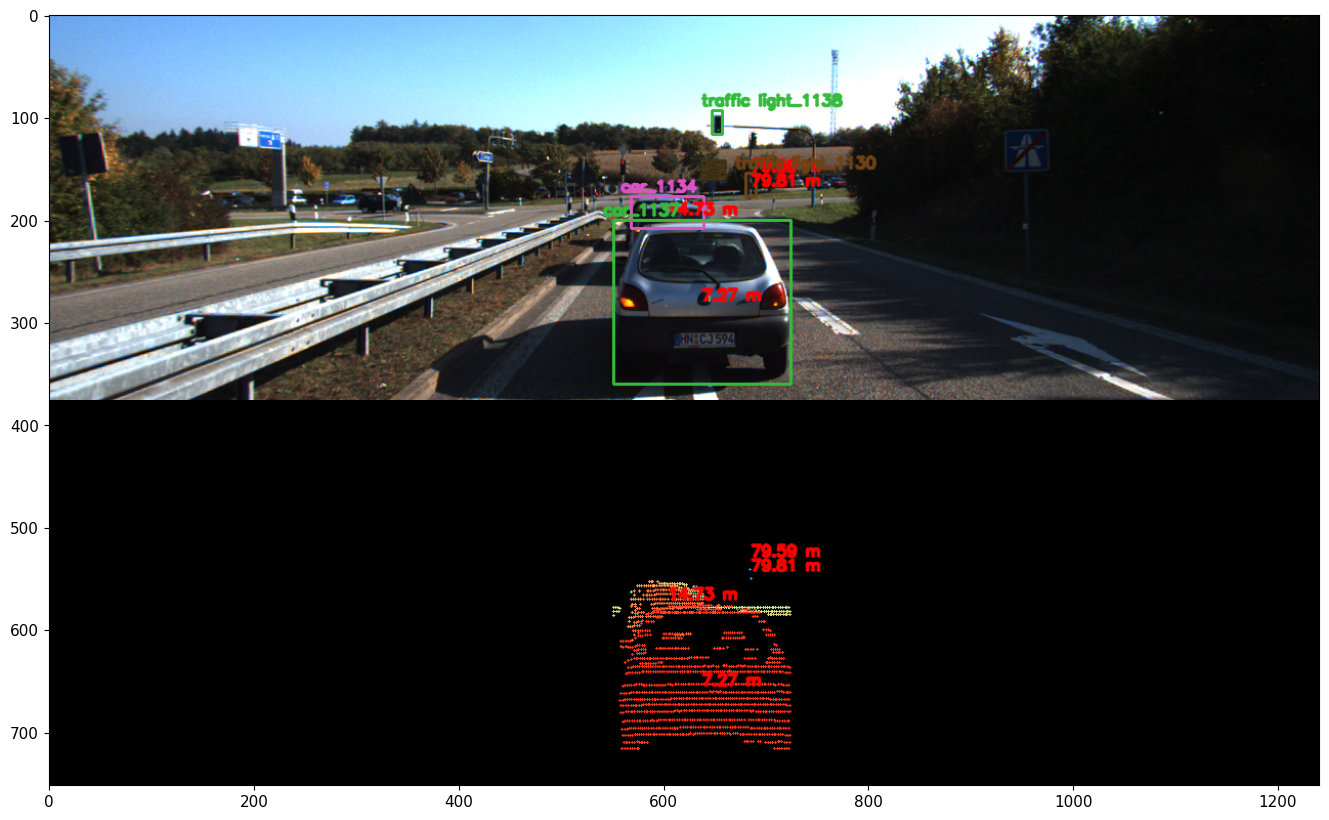

In [597]:
%matplotlib inline
plt.imshow(stacked)

In [598]:
# camera 2 frames per second
cam2_fps = 1/np.median(np.diff(cam2_total_seconds))
cam2_fps

h, w, _ = stacked.shape
out = cv2.VideoWriter('track_vid_stacked_with_filter_1.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      cam2_fps, 
                      (w,h))

for img in result_video:
    out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
out.release()